In [184]:
import numpy as np
import scipy

from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation
#from scipy.linalg import expm


import pulser
import qutip
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import RampWaveform, ConstantWaveform
from pulser.devices import Chadoq2, MockDevice

In [185]:
Omega = 1   * 2*np.pi
delta = 0.7 * 2*np.pi
U = 138e5

In [186]:
def MOF_reader(mol_str):
   with open('dataset_txt/'+mol_str+'_txt') as file:
    lines = file.readlines()
    N = len(lines)-1
    d = float(lines[0])
    plane_coords = np.array([lines[i].split() for i in range(1,N+1)], float)
    
    return d, plane_coords

In [187]:
d,coords = MOF_reader("BOHGOU")
coords

array([[-0.59281252,  0.31036275],
       [ 0.54163277, -0.97792151],
       [-0.21507733, -0.17761552],
       [-0.9401754 , -0.2000605 ],
       [-1.88137341, -0.78393097],
       [-0.0123522 ,  0.51937379],
       [-0.61238078,  0.92747345],
       [-0.01670646, -0.74835648],
       [-0.37936166, -1.23119976],
       [-0.9829448 , -1.2199801 ],
       [-1.28405231, -0.69667681],
       [-0.19995632, -1.80722773],
       [-1.25851485, -1.75668167],
       [ 0.27363888,  1.05081317],
       [ 0.57452215,  0.37887332],
       [-1.10236821,  1.27978712],
       [-0.39712929,  1.49127479],
       [-1.18493376,  0.4825209 ],
       [-2.47553784, -0.88791581],
       [ 1.09201526, -1.22479581]])

129.98694572404085


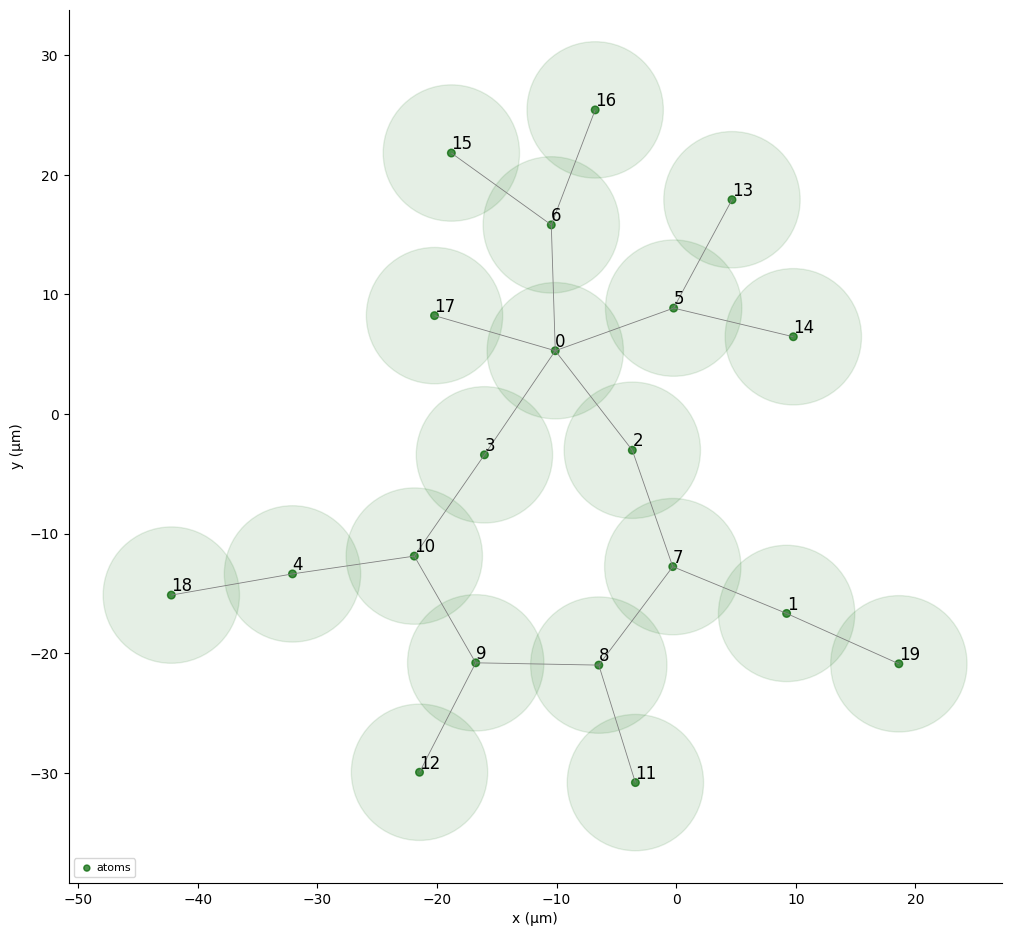

In [188]:
print((U/Omega)**(1/3))
n = 6
w = np.exp(1j*2*np.pi/(n))

n = len(coords)
def graph_desc(rNN):
    #G1 = [[rNN/(2*np.sin(np.pi/(3)))*(1+w**i).real,rNN/(2*np.sin(np.pi/(3)))*(w**i).imag] for i in range(3)] \
    #    + [[rNN/(2*np.sin(np.pi/(3)))*(-1.+w**1).real,rNN/(2*np.sin(np.pi/(3)))*(.5j+w**1).imag]] \
    #    + [[rNN/(2*np.sin(np.pi/(3)))*(-.8+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.5j+w**2).imag]] \
    #    + [[rNN/(2*np.sin(np.pi/(3)))*(-3+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.3j+w**2).imag]]
    
    #G1 = [[rNN/(2*np.sin(np.pi/(3)))*(1+w**i).real,rNN/(2*np.sin(np.pi/(3)))*(w**i).imag] for i in range(3)]
    #G1+= [[rNN/(2*np.sin(np.pi/(3)))*(-1+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(w**2).imag],\
    #    [rNN/(2*np.sin(np.pi/(3)))*(-2.5+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(w**2).imag] ]
    #G1 = [[rNN*i, 0] for i in range(n)]
    G1 = [rNN*np.array([c[0],c[1]]) for c in coords*d*5]
    #G1 = [[rNN/(2*np.sin(np.pi/(4)))*(w**i).real,rNN/(2*np.sin(np.pi/(4)))*(w**i).imag] for i in range(n)]
    return G1

#rNN = 11
#G1 = [[rNN/(2*np.sin(np.pi/(n)))*(w**i).real,rNN/(2*np.sin(np.pi/(n)))*(w**i).imag] for i in range(n)]
G1 = graph_desc(11)

Rij1 = np.zeros((n,n))
for i in range(n):
    for j in range(i):
        Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
        Rij1[j,i] = Rij1[i,j]
        
def excitation(j, total_sites):
    """The |0><0| projector operator on site j."""
    prod = [qutip.qeye(2) for _ in range(total_sites)]
    prod[j] = (qutip.qeye(2) + qutip.sigmaz()) / 2
    return qutip.tensor(prod)



def excitation2():
    """The |0><0| projector operator on site j."""
    prod = [qutip.qeye(2) for _ in range(n)]
    for j in range(n):
        prod[j] = (qutip.qeye(2) + qutip.sigmaz()) / 2
    return qutip.tensor(prod)


#excited = excitation2()
excited = excitation(0, len(coords))

qubits1 = dict(enumerate(G1))
reg1 = Register(qubits1)
reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True)

In [189]:
seq = Sequence(reg1, MockDevice)
seq.declare_channel("ising", "rydberg_global")


M = 15000
sampling_rate = 1/75

simple_pulse = Pulse.ConstantPulse(M, Omega, delta, 0)

seq.add(simple_pulse, "ising")
seq.measure(basis="ground-rydberg")

sim = QutipEmulator.from_sequence(seq,sampling_rate=sampling_rate)

results = sim.run(progress_bar=True, nsteps=5000)

10.0%. Run time:  49.13s. Est. time left: 00:00:07:22
20.0%. Run time:  98.82s. Est. time left: 00:00:06:35
30.0%. Run time: 149.02s. Est. time left: 00:00:05:47
40.0%. Run time: 198.94s. Est. time left: 00:00:04:58
50.0%. Run time: 248.53s. Est. time left: 00:00:04:08
60.0%. Run time: 298.87s. Est. time left: 00:00:03:19
70.0%. Run time: 349.81s. Est. time left: 00:00:02:29
80.0%. Run time: 401.90s. Est. time left: 00:00:01:40
90.0%. Run time: 453.79s. Est. time left: 00:00:00:50
Total run time: 503.53s


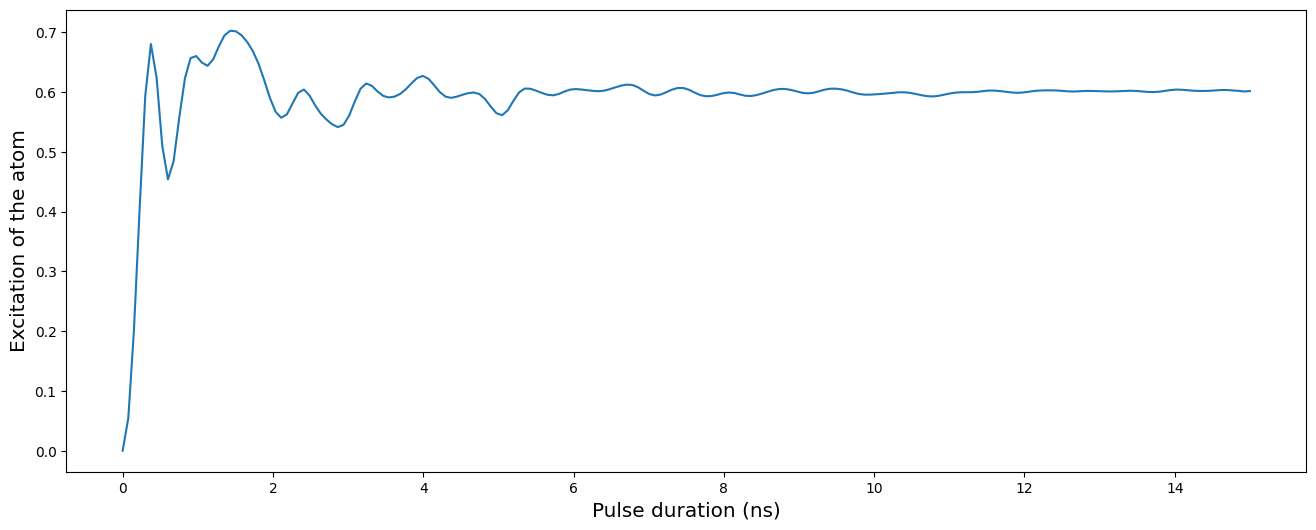

In [190]:

plt.figure(figsize=[16, 6])
results.plot(excited)
plt.xlabel("Pulse duration (ns)", fontsize="x-large")
plt.ylabel("Excitation of the atom", fontsize="x-large")
plt.show()

In [191]:
#print(results.expect([excited]))
arr = results.expect([excited])[0]

[ 0.          0.07537688  0.15075377  0.22613065  0.30150754  0.37688442
  0.45226131  0.52763819  0.60301508  0.67839196  0.75376884  0.82914573
  0.90452261  0.9798995   1.05527638  1.13065327  1.20603015  1.28140704
  1.35678392  1.4321608   1.50753769  1.58291457  1.65829146  1.73366834
  1.80904523  1.88442211  1.95979899  2.03517588  2.11055276  2.18592965
  2.26130653  2.33668342  2.4120603   2.48743719  2.56281407  2.63819095
  2.71356784  2.78894472  2.86432161  2.93969849  3.01507538  3.09045226
  3.16582915  3.24120603  3.31658291  3.3919598   3.46733668  3.54271357
  3.61809045  3.69346734  3.76884422  3.84422111  3.91959799  3.99497487
  4.07035176  4.14572864  4.22110553  4.29648241  4.3718593   4.44723618
  4.52261307  4.59798995  4.67336683  4.74874372  4.8241206   4.89949749
  4.97487437  5.05025126  5.12562814  5.20100503  5.27638191  5.35175879
  5.42713568  5.50251256  5.57788945  5.65326633  5.72864322  5.8040201
  5.87939698  5.95477387  6.03015075  6.10552764  6.

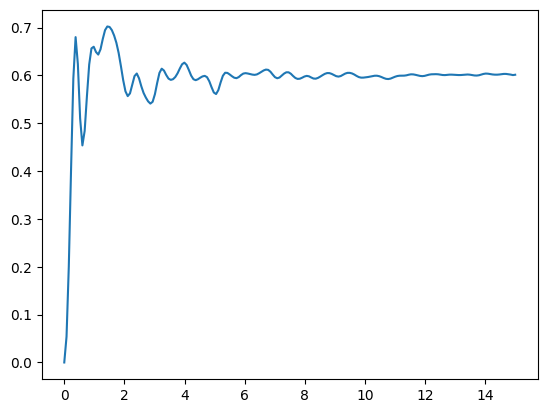

In [192]:

T = np.linspace(0,M/1000,int(sampling_rate*M))
print(T)
plt.plot(T,arr)

In [193]:
K = 100
rNN_vec = np.linspace(25,5.,K)
#print(rNN_vec[91])

In [194]:
 rNN_vec[24]

20.151515151515152

In [195]:

results = []
for k in range(K):
    if(k%10==0):
        print(k)
    rNN = rNN_vec[k]
    #G1 = [[rNN/(2*np.sin(np.pi/(n)))*(w**i).real,rNN/(2*np.sin(np.pi/(n)))*(w**i).imag] for i in range(n)]
    G1 = graph_desc(rNN_vec[k])
    #G1 = [[rNN/(2*np.sin(np.pi/(3)))*(1+w**i).real,rNN/(2*np.sin(np.pi/(3)))*(w**i).imag] for i in range(3)] \
    #        + [[rNN/(2*np.sin(np.pi/(3)))*(-1.+w**1).real,rNN/(2*np.sin(np.pi/(3)))*(.5j+w**1).imag]] \
    #        + [[rNN/(2*np.sin(np.pi/(3)))*(-.8+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.5j+w**2).imag]] \
    #        + [[rNN/(2*np.sin(np.pi/(3)))*(-3+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.3j+w**2).imag]]
    
    #Rij1 = np.zeros((n,n))
    #for i in range(n):
    #    for j in range(i):
    #        Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
    #        Rij1[j,i] = Rij1[i,j]

    qubits1 = dict(enumerate(G1))
    reg1 = Register(qubits1)

    seq = Sequence(reg1, MockDevice)
    seq.declare_channel("ising", "rydberg_global")

    #simple_pulse = Pulse.ConstantPulse(M, Omega, delta, 0)

    _omega = ConstantWaveform(M, Omega/10)
    #_omega = RampWaveform(M, rNN_vec[24], rNN_vec[0])
    #_delta = RampWaveform(M, 24, 4)  # Duration: 1000ns, linear sweep from -20 to 20 rad/µs
    _delta = ConstantWaveform(M, 0.7*2*np.pi)
    
    simple_pulse = Pulse(_omega,_delta,phase=0)
    
    seq.add(simple_pulse, "ising")
    seq.measure(basis="ground-rydberg")

    sim = QutipEmulator.from_sequence(seq,sampling_rate=sampling_rate)

    result = sim.run(progress_bar=False, nsteps=50000)

    results.append(result.expect([excited])[0])

0
10
20
30
40
50
60
70
80
90


In [ ]:
results = np.array(results)

#T = np.linspace(0,4,int(M*sampling_rate))

fig, ax = plt.subplots()
l, = plt.plot(T,results[0,:])
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_ylim([0,2])

def animate(i):
    l.set_data(T,results[i,:])
    ax.set_title(rNN_vec[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, interval=25, frames=K)

       
HTML(ani.to_jshtml())

In [ ]:
#print(dt)
#print((scipy.fft.fftfreq(M*10, dt/10)))
#print(results)
#print(1/dt)
#print(scipy.fft.fftfreq(M, dt))
int(M*sampling_rate)

200

In [ ]:
# For better frequency resolution



FFT = np.zeros((K,int(M*sampling_rate//2)))
FFTw = np.zeros((K,int(M*sampling_rate//2)))
dt = T[1]-T[0]
xf = scipy.fft.fftfreq(int(M*sampling_rate), dt)[:int(M*sampling_rate//2)]

from scipy.signal.windows import blackman
#window = blackman(T.shape[-1]//samplinsg_rate+1)

for i in range(K):
    results_sampled = results[i,:]

    FFT[i,:] = 2/M/sampling_rate*np.abs(scipy.fft.fft(results_sampled)[:int(M*sampling_rate//2)])
    #FFTw[i,:] = 2/M*np.abs(scipy.fft.fft(results_sampled*window)[:M//sampling_rate//2])
    


In [ ]:
print(len(xf))
print(xf)


100
[0.         0.06633333 0.13266667 0.199      0.26533333 0.33166667
 0.398      0.46433333 0.53066667 0.597      0.66333333 0.72966667
 0.796      0.86233333 0.92866667 0.995      1.06133333 1.12766667
 1.194      1.26033333 1.32666667 1.393      1.45933333 1.52566667
 1.592      1.65833333 1.72466667 1.791      1.85733333 1.92366667
 1.99       2.05633333 2.12266667 2.189      2.25533333 2.32166667
 2.388      2.45433333 2.52066667 2.587      2.65333333 2.71966667
 2.786      2.85233333 2.91866667 2.985      3.05133333 3.11766667
 3.184      3.25033333 3.31666667 3.383      3.44933333 3.51566667
 3.582      3.64833333 3.71466667 3.781      3.84733333 3.91366667
 3.98       4.04633333 4.11266667 4.179      4.24533333 4.31166667
 4.378      4.44433333 4.51066667 4.577      4.64333333 4.70966667
 4.776      4.84233333 4.90866667 4.975      5.04133333 5.10766667
 5.174      5.24033333 5.30666667 5.373      5.43933333 5.50566667
 5.572      5.63833333 5.70466667 5.771      5.83733333 5.

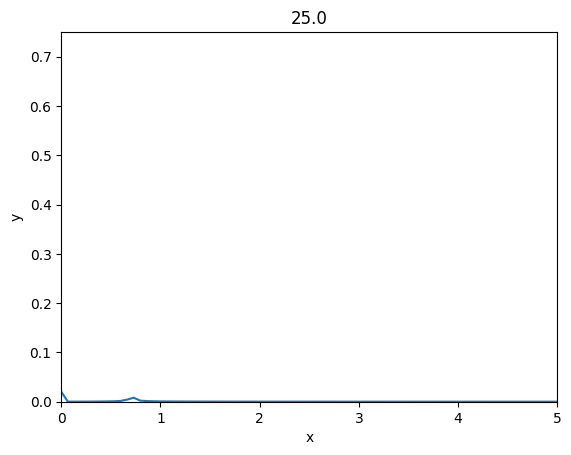

In [ ]:
fig, ax = plt.subplots()
l, = plt.plot(xf,FFT[0,:])
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_ylim([0,0.75])
ax.set_xlim([0,5])

def animate(i):
    l.set_data(xf,FFT[i,:])
    ax.set_title(rNN_vec[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, interval=100, frames=K)

       
HTML(ani.to_jshtml())

# ani.save('FFT_rNN_hexa.gif')

In [ ]:
np.log(FFT[0,:])

array([-3.90238087, -8.67357609, -8.54224235, -8.36001193, -8.1466537 ,
       -7.9074143 , -7.64443863, -7.34053543, -6.96277426, -6.43949919,
       -5.46127817, -4.80485297, -6.12006518, -6.6408874 , -6.96468292,
       -7.19765089, -7.38377713, -7.52975702, -7.6537911 , -7.76334533,
       -7.85610464, -7.93917494, -8.01689751, -8.08404512, -8.14603027,
       -8.20608944, -8.25820616, -8.30700951, -8.35645812, -8.39851453,
       -8.43805259, -8.48119205, -8.51563862, -8.54755912, -8.59136673,
       -8.6185333 , -8.64637674, -8.66290322, -8.70564484, -8.7083801 ,
       -8.73968269, -8.76517354, -8.79958099, -8.8151169 , -8.83553951,
       -8.86161094, -8.87685561, -8.89467059, -8.91745497, -8.93118206,
       -8.94660668, -8.9674563 , -8.9793396 , -8.99242153, -9.01244372,
       -9.02207477, -9.03252435, -9.05390784, -9.05974967, -9.06569666,
       -9.11302795, -9.09693724, -9.09601385, -9.09779224, -9.10370588,
       -9.1920947 , -9.15139865, -9.15617644, -9.17310371, -9.17

In [ ]:
print(Omega/2/np.pi*np.sqrt(n))

3.0


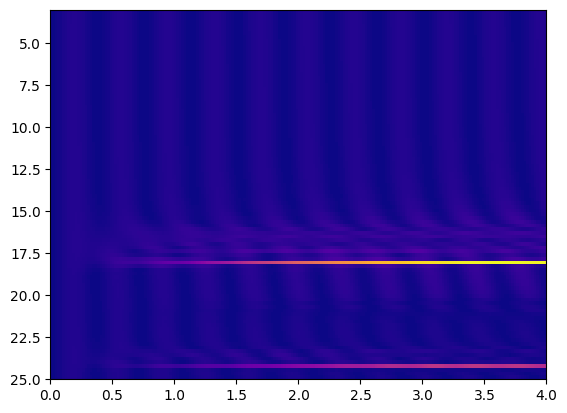

In [ ]:

plt.imshow(results, cmap='plasma', interpolation='nearest',extent=(0,4,25,3), aspect='auto')
plt.show()

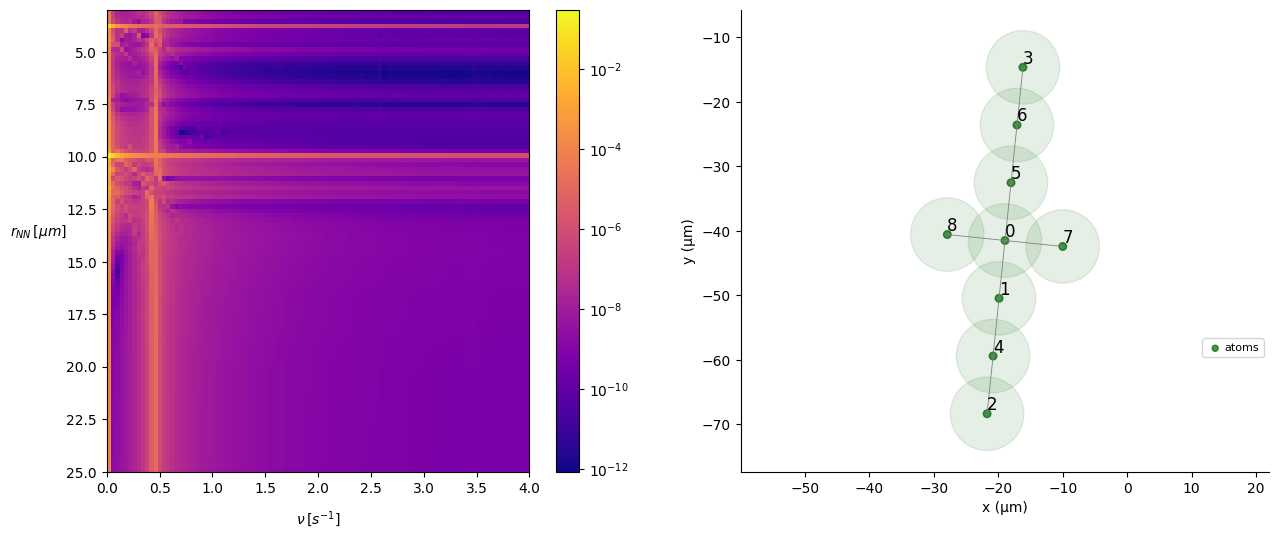

In [ ]:
#fftbis = np.array([FFT[i,:],rNN_vec[i] for i in range(100)])
#print(fftbis.shape)
#fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
plt.rcParams['text.usetex'] = False
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.set_ylabel(r'$r_{NN}\, [\mu m]$',rotation=0,labelpad=20)#, loc='top')
ax1.set_xlabel(r'$\nu\,[s^{-1}]$',rotation=0,labelpad=10)#, loc='right')
im = ax1.imshow(np.log(FFT[:,:]),cmap='plasma',origin='lower', interpolation='nearest', extent=(0,4,25,3), aspect='auto')
#ax2.imshow(np.log(FFTw),cmap='plasma',origin='lower', interpolation='nearest', extent=(0,4,25,0.5))
#ax1.setgrid()
ax1.set_title("")

import matplotlib.ticker as ticker
def fmt(x, pos):
    #a, b = '{:.2e}'.format(x).split('e')
    #b = int(b)
    return r'$10^{{{}}}$'.format(int(x))

plt.colorbar(im, format=ticker.FuncFormatter(fmt))
#fig.colorbar(im)
#ax1.grid(alpha=0.5, linestyle='-', linewidth=1)
G1 = graph_desc(11)

qubits1 = dict(enumerate(G1))
reg1 = Register(qubits1)
reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True,custom_ax=ax2)


plt.show()